# 2º Trabalho Prático: Planejamento de Caminhos

## Introdução

1. Objetivos do trabalho
2. Detalhamento do problema
3. Bibliotecas utilizadas
4. Tecnicas utilizadas e suas diferenças

#### Importação de Bibliotecas

In [1]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import math
import time
import numpy as np
import heapq
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#### Classes e Funções Compartilhadas

1. Decisão de criar classes e subclasses para os objetos contidos no coppelia
2. Decisão de manter as funções de movimentação por caminho e calculos cinematicos dentro da classe CoppeliaRobot
3. Dificuldades com o modelo cinematico inverso e com o youBot
4. Decisão de manter o robo sempre seguindo em frente (sem deslocamento lateral) e realizando curvas somente nas viradas do caminho -> Inicialmente pensado para o youbot
5. Decisão de aumentar a margem de erro -> dificuldades com o terreno 

In [2]:
client = RemoteAPIClient()
sim = client.require('sim')

class CoppeliaObject:
    
    def __init__ (self, name):
        self.name = name
        self.handle = sim.getObject (name)
        self.update_location ()
        
    def new_location (self, position, orientation):
        sim.setObjectPosition (self.handle, position)
        sim.setObjectOrientation (self.handle, orientation)
        self.update_location ()
        
    def update_location (self):
        self.global_position = sim.getObjectPosition (self.handle)
        self.global_orientation = sim.getObjectOrientation (self.handle)

class CoppeliaRobot (CoppeliaObject):
    
    def __init__ (self, name, length, wheels, laser = None):
        # wheel_joints recebe um vetor de objetos do tipo Coppelia_Wheel
        self.length = length
        self.wheels = wheels
        self.laser = laser
        CoppeliaObject.__init__ (self, name)

    def calc_linear_velocity (self, position, orientation):
        delta_pos = np.array (position) - np.array (self.global_position[:2])
        delta_ori = orientation - self.global_orientation[2]
        q_dot = np.array ((delta_pos[0], delta_pos[1], delta_ori))
        return q_dot

    def inverse_kinematics_omnidirectional (self, velocity, orientation):
        L = self.length
        direct_matrix = self.wheels[0].radius / 3 * np.array([[-np.sqrt(3),          0, np.sqrt(3)],
                                                              [          1,         -2,          1],
                                                              [      1 / L,      1 / L,      1 / L]])
        inverse_matrix = np.linalg.inv (rotation_z (orientation) @ direct_matrix)
        angular_velocity = inverse_matrix @ velocity
        return angular_velocity

    def follow_path (self, path):
        for stop in path:
            t = 0
            last_time = time.time()
            while np.linalg.norm (self.global_position[:2] - stop) > 0.1 and t < 5:
                angle = np.arctan2 (stop[1], stop[0])
                linear_velocity = self.calc_linear_velocity (stop, angle)
                wheels_velocity = self.inverse_kinematics_omnidirectional (linear_velocity, angle)
                for i in range (3):
                    self.wheels[i].set_velocity (wheels_velocity[i])
                self.update_location ()
                t = t + time.time() - last_time
                last_time = time.time()

class CoppeliaWheel (CoppeliaObject):
    
    def __init__ (self, name, radius):
        self.radius = radius
        CoppeliaObject.__init__ (self, name)

    def set_velocity (self, velocity):
        sim.setJointTargetVelocity (self.handle, velocity)

class CoppeliaLaser (CoppeliaObject):
    
    def __init__ (self, name, laser_range_data, laser_angle_data):
        self.laser_range_data = laser_range_data
        self.laser_angle_data = laser_angle_data

In [3]:
# Normalize angle to the range [-pi,pi)
def normalize_angle (angle):
    
    return np.mod (angle + np.pi, 2 * np.pi) - np.pi

In [4]:
def rotation_z (theta):
    return np.array ([[ np.cos(theta) , -np.sin(theta) , 0 ],
                      [ np.sin(theta) ,  np.cos(theta) , 0 ],
                      [ 0             ,  0             , 1 ]])
  
def rotation_y (theta):
    return np.array ([[  np.cos(theta) , 0 , np.sin(theta) ],
                      [  0             , 1 , 0             ],
                      [ -np.sin(theta) , 0 , np.cos(theta) ]])

def rotation_x (theta):
    return np.array ([[ 1 , 0             ,  0             ],
                      [ 0 , np.cos(theta) , -np.sin(theta) ],
                      [ 0 , np.sin(theta) ,  np.cos(theta) ]])

def rotation_matrix (alpha, beta, gamma):
    
    return rotation_z (alpha) @ rotation_y (beta) @ rotation_x (gamma)

def homogeneous_transformation_matrix (rotation_matrix, translation_vector):
    
    matrix = np.column_stack ((rotation_matrix, translation_vector[:3]))
    matrix = np.row_stack ((matrix, [0, 0, 0, 1]))
    return matrix

def reverse_transformation (a_to_b_orientation, a_to_b_position):
    
    b_to_a_rotation = np.transpose (rotation_matrix (*np.flip (a_to_b_orientation)))
    b_to_a_position = -1 * b_to_a_rotation @ a_to_b_position[:3]
    return homogeneous_transformation_matrix (b_to_a_rotation, b_to_a_position)

def composite_transformation (a_to_b_rotation, a_to_b_position, b_to_c_rotation, b_to_c_position):
    
    a_to_c_rotation = b_to_c_rotation @ a_to_b_rotation
    a_to_c_position = homogeneous_transformation_matrix (b_to_c_rotation, b_to_c_position) @ a_to_b_position
    return homogeneous_transformation_matrix (a_to_c_rotation, a_to_c_position)

def to_world_transformation_matrix (c_object):
    
    object_to_world_rotation = rotation_matrix (*np.flip (c_object.global_orientation))
    return homogeneous_transformation_matrix (object_to_world_rotation, c_object.global_position)

def to_robot_transformation_matrix (c_object, robot):
    
    world_to_robot_rotation = np.transpose (rotation_matrix (*np.flip (robot.global_orientation)))
    world_to_robot_position = -1 * world_to_robot_rotation @ robot.global_position[:3]

    object_to_world_rotation =  rotation_matrix (*np.flip (c_object.global_orientation))
    return composite_transformation (object_to_world_rotation, c_object.global_position + [1], world_to_robot_rotation, world_to_robot_position)

def transform_laser_data (laser_data, laser_to_world_transformation):
    
    obstacles_list = []
    for ang, dist in laser_data:
        # Quando o feixe não acerta nada, retorna o valor máximo (5)
        if dist <= 4.9:
            x = dist * np.cos (ang)
            y = dist * np.sin (ang)
            c = 1 if ang < 0 else 0
            obstacles_list.append (np.append (laser_to_world_transformation @ [x, y, 0, 1], [c])) 
    return obstacles_list

In [5]:
hokuyo = CoppeliaLaser ("./Pioneer_p3dx/fastHokuyo", "hokuyo_range_data", "hokuyo_angle_data")
pioneer = CoppeliaRobot ("./Pioneer_p3dx", 0.381, [], hokuyo)
pioneer.wheels.append (CoppeliaWheel ("/Pioneer_p3dx_rightMotor", 0.0975))
pioneer.wheels.append (CoppeliaWheel ("/Pioneer_p3dx_leftMotor", 0.0975))
goal = CoppeliaObject ("./ReferenceFrame")

## Planejamento de Caminhos com o Algoritmo de Campos Potênciais

#### Função de leitura de Laser

Esta é uma das principais funções para o funcionamento deste método. Funciona recebendo como parâmetros as informações necessárias do Laser, como seu nome e o que ele deve pegar e retorna um vetor com as informações de distância e ângulos captadas pelo Laser. No caso, a sua
limitação se dá pelo fato de que o Laser não captura informações que estejam a mais de 5 metros de distância, por isso a anulação de valores
com o valor 5 na função de repulsão. 

In [6]:
def read_sensor_data (range_data_signal_id = "hokuyo_range_data", angle_data_signal_id = "hokuyo_angle_data"):
    
    while sim.getStringSignal (range_data_signal_id) == None:
        continue
        
    string_range_data = sim.getStringSignal (range_data_signal_id)
    string_angle_data = sim.getStringSignal (angle_data_signal_id)

    raw_range_data = sim.unpackFloatTable (string_range_data)
    raw_angle_data = sim.unpackFloatTable (string_angle_data)

    return np.array ([raw_angle_data, raw_range_data]).T

#### Funções Campos Potenciais

Neste trecho, foi-se definido as funções de atração e repulsão para locomoção do robô. Com efeito, elas se baseiam nas leituras de posição atual do robô, do goal e do obstáculo (obtida com o Laser). No caso, a força de atração é baseada na diferença entre a posição do 
goal e do robô, multiplicada por um ganho constante. Note que esta função é retorna um vetor. 

Por fim, a foça de repulsão atua com a posição atual do robô, posição do obstáculo, um fator R para distância máxima permitida e um ganho constante. Neste caso,ela é necessária para que se evite a colisão do robô e este consiga efetuar sua trajetória sem ficar preso. No caso, note que esta também retorna um vetor e é inversalmente proporcional com a distância entre o robô e o obstáculo, i.e., quanto mais próxima do obstáculo, maior deve ser.

In [7]:
def calc_attraction_force (robot, goal, k_att):
    delta_pos = np.array (goal.global_position[:2]) - np.array (robot.global_position[:2])
    return k_att * delta_pos

def calc_repulsion_force (robot, laser, k_rep = .1):

    max_dist = 4

    laser_to_robot_transformation = to_robot_transformation_matrix (laser, robot)
    laser_data = read_sensor_data (robot.laser.laser_range_data, robot.laser.laser_angle_data)
    robot_to_world_transformation = to_world_transformation_matrix (robot)
    laser_to_world_transformation = robot_to_world_transformation @ laser_to_robot_transformation
    transformed_laser_data = transform_laser_data (laser_data, laser_to_world_transformation)

    repulsion = np.array ((0, 0))
    
    for beam in transformed_laser_data:
        if beam[0] < max_dist and beam[0] > 0:
            x_dist = robot.global_position[0] - beam[0]
            y_dist = robot.global_position[1] - beam[0]
            distance = np.linalg.norm (np.array ((x_dist, y_dist)))
            
            force_direction = np.array ((x_dist, y_dist)) / distance
            inverse_dist_diff = 1 / distance - 1 / max_dist
            force_module = k_rep / (distance ** 2)
            
            repulsion = repulsion + force_module * inverse_dist_diff * force_direction
        
    return repulsion

#### Funções para o funcionamento do método.
Primeiramente, definiu-se o caminho do robô, dos componentes e do Laser, para que se obtenha o Handle destes objetos. A partir daí, utilizando as funções de getObjectPosition e getObjectOrientation, obtivemos as posições iniciais do robô. A partir daí, fez-se o Path do Goal que é um referenceFrame obtido do Coppeliae obteve sua posição e orientação. Note que este é fixo durante todo código. Após isso, define-se cotas superiores de velocidade que o robô pode alcançar e realiza-se um laço de interação while que continua rodando até que a posição final do robô esteja com erro de 0.05 em relação ao Goal. Dentro desta interação, busca-se atualizar constantemente a posição do robô e sua orientação, para que se possa mudar o valor da força de atração entre o robô e o Goal a medida que este se aproxima do objetivo.
    
Dentro deste while, chama-se continuamente a função de leitura do laser baseada na posição atual do robô que retorna o vetor com valores de distância e ângulos. Para que se tenha um melhor controle sobre estes valores, realiza-se um outro laço de iteração para filtrar os valores que são menores que uma tolerância de 5, são removidos (pois retornariam valores espúrios e perderíamos memória calculando valores não válidos devido a distância). Daí, realizamos o cálculo da força de repulsão baseada nesses valores filtrados.
    
Por fim, realizamos os cálculos somando todas as forças de repulsão e definindo x_force e y_force como sendo o primeiro e o segundo valor (respectivamente) do vetor da soma da força de atração e todas as de repulsão. Fizemos isso para aplicar o controlador de Lucas-Orio, e a partir dos valores calculados de velocidade linear e ângular, aplicamos as restrições de velocidades máximas e mínimas permitidas, para que se tenha um limite para estas. Após isso, definimos as velocidades da roda do robô diferencial e ele continua andando até que esteja a uma distância menor que 0.05 do Goal
    

In [8]:
sim.startSimulation ()

L = 0.381
r = 0.0975
maxv = 1.5
maxw = np.deg2rad(45)

goal_distance = np.linalg.norm (np.array (goal.global_position[:2]) - np.array (pioneer.global_position[:2]))

while goal_distance > 0.1:

    pioneer.update_location ()        
    robot_config = np.array ([pioneer.global_position[0], pioneer.global_position[1], pioneer.global_orientation[2]])        

    attraction_force = calc_attraction_force (pioneer, goal, 0.1)
    repulsion_force = calc_repulsion_force (pioneer, hokuyo, 1) 
    #print ("Força de Atração: ", attraction_force)
    #print("Força de Repulsão ", repulsion_force)

    x_force, y_force = attraction_force + repulsion_force

    kr = 1
    kt = 2

    
    v = kr*(x_force*np.cos(pioneer.global_orientation[2]) + y_force*np.sin(pioneer.global_orientation[2]))
    w = kt*(np.arctan2(y_force,x_force) - robot_config[2])
            
    # Limit v,w to +/- max
    
    #print("Velocidade do robô ",v," velocidade angular do robot ", w, "\n")
    v = max (min (v, maxv), -maxv)
    w = max (min (w, maxw), -maxw)

    #print("Velocidade do robô 2: ",v," velocidade angular do robot 2: ", w, "\n")

    vr = ((2 * v) + (w * pioneer.length)) / (2 * pioneer.wheels[0].radius)
    vl = ((2 * v) - (w * pioneer.length)) / (2 * pioneer.wheels[0].radius)
    
    pioneer.wheels[0].set_velocity (vr)
    pioneer.wheels[1].set_velocity (vl)

    goal_distance = np.linalg.norm (np.array (goal.global_position[:2]) - np.array (pioneer.global_position[:2]))
        
pioneer.wheels[0].set_velocity (0)
pioneer.wheels[1].set_velocity (0)

sim.stopSimulation()
time.sleep (5)

AttributeError: 'CoppeliaLaser' object has no attribute 'global_orientation'

## Planejamento de Caminhos com o Algoritmo Roadmap

### Implementação

#### Funções Relativas a Leitura e Impressão de Imagens

In [ ]:
def read_binary_image (image_address):
    
    image = mpimg.imread (image_address)
    for row in range (len (image)):
        for col in range (len (image[row])):
            image[row][col] = 1 if image[row][col] < 1 else 0
            
    return image

def print_world_grid (world_grid, img_id = ""):
    
    x_len = len (world_grid[0])
    y_len = len (world_grid)
    
    figure = plt.figure (figsize = (10, 10 * y_len / x_len), dpi = 100)
    ax = figure.add_subplot (111, aspect = 'equal')

    ax.grid (which = 'major', axis = 'both', linestyle = '-', color = 'k', linewidth = .5)
    ax.set_xticks (np.arange (0, x_len))
    ax.set_yticks (np.arange (0, y_len))
    
    ax.imshow (1 - world_grid, cmap = 'Blues', extent = (0, x_len, 0, y_len), alpha = 0.6)
    #plt.savefig(f"world_{img_id}.png")
    #plt.close()

#### Classes de Dados

1. Adaptação do código para discretizar o mundo
2. Decisão de não utilizar um buffer
3. Consequencias de não utilizar um buffer - Sem movimento diagonal
4. Decisão de utilizar heuristica Manhattan distance
5. Estrutura que permite a utilização como BFS

In [ ]:
class World:
    
    def __init__ (self, image_address, real_dimensions):
        self.image_address = image_address
        self.world_matrix = read_binary_image (self.image_address)
        self.real_dimensions = real_dimensions
        self.scale = self.world_matrix.shape[:2] / self.real_dimensions
        
    def is_cell_area_free (self, row, col, cell_size):
        area_size = cell_size * self.scale
        
        left = int (col * area_size[0])
        right = int ((col + 1) * area_size[0])
        top = int (row * area_size[1])
        bottom = int ((row + 1) * area_size[1])
        
        return 1 if np.sum (self.world_matrix[top:bottom, left:right]) == 0 else 0
        
    def discretize_world (self, cell_size = 1):
        num_rows, num_cols = (self.real_dimensions / cell_size).astype(int)
        grid = np.zeros ((num_rows, num_cols))
        
        for row in range (num_rows):
            for col in range (num_cols):
                grid[row][col] = self.is_cell_area_free (row, col, cell_size)
                
        print_world_grid(grid)
        return grid

In [ ]:
class Node:

    def __init__ (self, grid_position, parent, current_cost):
        self.grid_position = grid_position
        self.parent = parent
        self.current_cost = current_cost
        self.priority_score = current_cost # Se a função calc_priority_score não é chamada, o algoritmo funciona como uma busca em largura (BFS)

    def __lt__ (self, other):
        return self.priority_score < other.priority_score

    def manhattan_distance (self, goal_pos):
        return abs (self.grid_position[0] - goal_pos[0]) + abs (self.grid_position[1] - goal_pos[1])
        
    def calc_priority_score (self, goal_pos):
        self.heuristic_cost = self.manhattan_distance (goal_pos)
        self.priority_score = self.current_cost + self.heuristic_cost

#### Funções Relativas a Busca de Caminhos com o Algoritmo A*

1. Decisão de utilizar o algoritmo A*
2. Decisão de não inicializar todas as celulas como vertices, gerando apenas os vertices encontrados pelo algoritmo A*
3. Decisão de usar os valores 2 para explorada e 3 para caminho -> Melhor visualização e sem necessidade de uma matriz auxiliar
4. Decisão de utilizar heapq -> Iterativo e já implementado em arvore - sem necessidade de implementar algoritmos de ordenação que não seriam otimos

In [ ]:
def is_cell_invalid (cell, world):
    
    if cell [0] < 0: return True
    if cell [1] < 0: return True
    if cell [0] >= len (world[0]): return True
    if cell [1] >= len (world): return True
        
    return False

def reconstruct_path_to (last_node, world):

    path = [last_node.grid_position]
    world[last_node.grid_position[1]][last_node.grid_position[0]] = 3
    
    while last_node.parent is not None:
        path.append(last_node.parent.grid_position)
        last_node = last_node.parent
        world[last_node.grid_position[1]][last_node.grid_position[0]] = 3

    return path, world

def A_star (start, end, binary_world):

    frontier = []
    path = []
    binary_world[start[1]][start[0]] = 1
    heapq.heappush (frontier, Node (start, None, 0))

    while len(frontier) > 0:
        current_node = heapq.heappop(frontier)

        if not (current_node.grid_position - end).any():
            path, binary_world = reconstruct_path_to (current_node, binary_world)
            break

        for shift_one in [[0, 1], [0, -1], [1, 0], [-1, 0]]:
            neighbor_position = (current_node.grid_position + shift_one).astype(int)
            
            if is_cell_invalid (neighbor_position, binary_world): continue
            if binary_world[neighbor_position[1]][neighbor_position[0]] == 0: continue # 0 -> OBSTACULO
            if binary_world[neighbor_position[1]][neighbor_position[0]] == 2: continue # 2 -> EXPLORADO
            else: binary_world[neighbor_position[1]][neighbor_position[0]] = 2

            neighbor = Node (neighbor_position, current_node, current_node.current_cost + 1)
            neighbor.calc_priority_score (end)
            heapq.heappush (frontier, neighbor)

    
    print_world_grid (binary_world)
        
    return path

![SegmentLocal](imagens/gif_a_star.gif "segment")

#### Funções Auxiliares de Transformação, Controle e Integração

1. Criação de funções de transformação de coordenadas -> Decisão de não manter o ponto de origem no centro do mapa para facilitar o acesso direto na matriz -> sem necessidade de calculos para saber se um ponto está ocupado, já foi explorado ou é valido
2. Utilização de função auxiliar find_goal para facilitar a testagem do código e diminuir o tamanho e facilitar a reprodução dos testes

In [ ]:
# Move o ponto de origem do centro do mundo para o canto superior esquerdo da grade e encontra a celula correspondente
def calc_grid_position (global_pos, cell_size, grid_size):

    x_pos = np.floor (global_pos[0] / cell_size + grid_size[0] / 2)
    y_pos = np.floor (-global_pos[1] / cell_size + grid_size[1] / 2)

    return np.array ((x_pos, y_pos)).astype(int)

def calc_map_position (grid_pos, cell_size, grid_size):

    x_pos = (grid_pos[0] + 0.5 - grid_size[0] / 2) * cell_size
    y_pos = -(grid_pos[1] + 0.5 - grid_size[1] / 2) * cell_size

    return np.array ((x_pos, y_pos))

def find_goal (robot, goal, world_map, cell_size):

    robot_cell = calc_grid_position (robot.global_position, cell_size, [len (world_map[0]), len (world_map)])
    goal_cell = calc_grid_position (goal.global_position, cell_size, [len (world_map[0]), len (world_map)])
    
    grid_path = A_star (robot_cell, goal_cell, world_map)

    world_path = [calc_map_position (stop, cell_size, [len (world_map[0]), len (world_map)]) for stop in grid_path]
    
    robot.follow_path (np.flip (world_path, 0))

### Testes e Análise de Resultados

1. Necessidade de setar velocidade das rodas para 0 para evitar movimentos involuntarios desde o inicio da execução ate o primeiro comando de velocidade
2. Restrições quanto ao tamanho da celula: Tamanho da celula deve ser um divisor comum das dimensões do mundo (para não causar divergencia da imagem projetada com as axes do grafico) e deve ser maior que o robô (0.27) (consequencia da ausencia de buffer)
3. Dificuldades com a geração da imagem da caverna e em determinar a inclinação real do terreno devido a ausencia de um mapa com as paredes (tive que utilizar a imagem da textura, que não era confiavel quanto a margem real dos obstaculos)
4. Criação de mapas separados para cada robo: Evitar colisões e interferencias

Descrição do teste

In [ ]:
sim.loadScene ("C:/Users/tatia/Desktop/UFMG/RM/TP2/mapas/cave_robotino.ttt")
sim.startSimulation ()

robotino = CoppeliaRobot ("/robotino", 0.135, [])

robotino.wheels.append (CoppeliaWheel ("/wheel0_joint", 0.040))
robotino.wheels.append (CoppeliaWheel ("/wheel1_joint", 0.040))
robotino.wheels.append (CoppeliaWheel ("/wheel2_joint", 0.040))

for i in range (3):
    robotino.wheels[i].set_velocity (0)

goal = CoppeliaObject ("/Goal")

world = World ("C:/Users/tatia/Desktop/UFMG/RM/TP2/mapas/imagens/cave.png", np.array([40,40]))
world_map = world.discretize_world (0.4)

find_goal (robotino, goal, world_map, 0.4)

sim.stopSimulation ()
time.sleep (5)

Analise de resultados

Descrição do teste

Tempo de Execução: 68.79868006706238


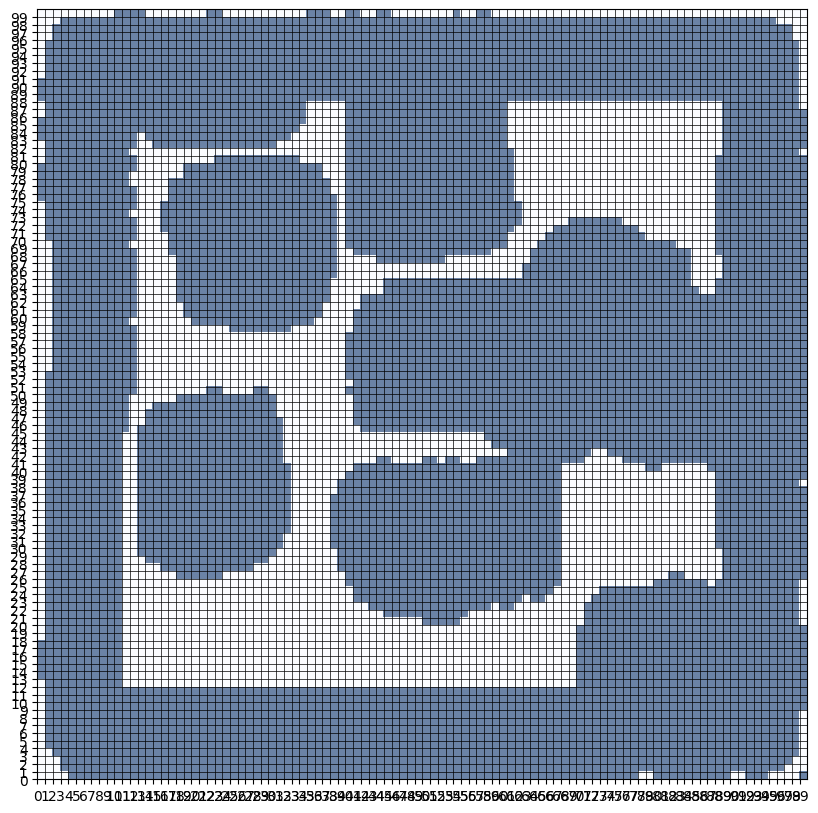

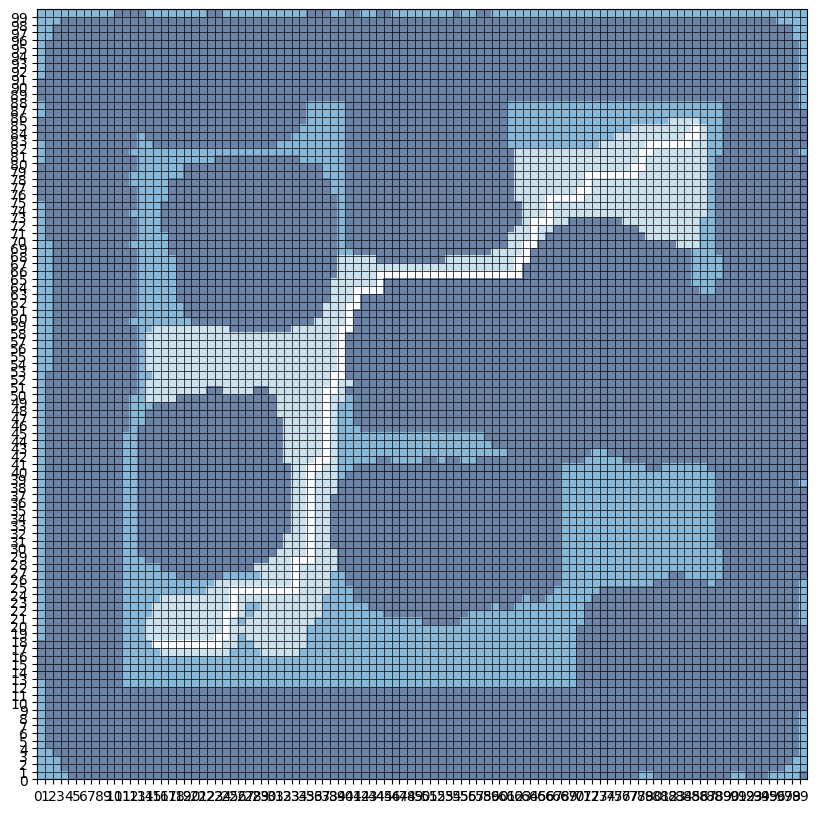

In [ ]:
sim.loadScene ("C:/Users/tatia/Desktop/UFMG/RM/TP2/mapas/maze_robotino.ttt")
sim.startSimulation ()

robotino = CoppeliaRobot ("/robotino", 0.135, [])

robotino.wheels.append (CoppeliaWheel ("/wheel0_joint", 0.040))
robotino.wheels.append (CoppeliaWheel ("/wheel1_joint", 0.040))
robotino.wheels.append (CoppeliaWheel ("/wheel2_joint", 0.040))

for i in range (3):
    robotino.wheels[i].set_velocity (0)

goal = CoppeliaObject ("/Goal")

world = World ("C:/Users/tatia/Desktop/UFMG/RM/TP2/mapas/imagens/maze.png", np.array([20,20]))
world_map = world.discretize_world (0.4) # Tamanho da celula deve ser um divisor comum das dimensões do mundo e deve ser maior que o robô (0.27)

find_goal (robotino, goal, world_map, 0.4)

sim.stopSimulation ()
time.sleep (5)

Analise de resultados

## Conclusão

## Bibliografia

In [ ]:
Em resumo, este trabalho nos proporcionou uma experiência valiosa no campo da robótica, permitindo-nos explorar diferentes algoritmos e técnicas de planejamento e navegação. Os algoritmos de Roadmap e de Campos Potenciais demonstraram ser eficazes na busca de caminhos e na navegação em ambientes desafiadores. No entanto, enfrentamos dificuldades na implementação do algoritmo de Campos Potenciais. Esta experiência nos proporcionou insights importantes sobre os desafios práticos e teóricos do planejamento de trajetórias para robôs móveis, preparando-nos para futuros projetos e aprendizados nesta área.